# Деревья решений. Домашняя работа №3
Ишмаева Бэлла, БЭК 142

In [12]:
import numpy as np
import pandas as pd 

df = pd.read_csv('california.dat')

In [13]:
df.head()

,Longitude,Latitude,HousingMedianAge,TotalRooms,TotalBedrooms,Population,Households,MedianIncome,MedianHouseValue
0,-117.03,32.78,17,5481,1618,2957,1537,2.5707,171300
1,-118.23,33.80,26,239,135,165,112,1.3333,187500
2,-122.46,37.71,39,2076,482,1738,445,3.1958,232100
3,-122.06,37.94,19,4005,972,1896,893,2.5268,235700
4,-122.87,38.68,32,4073,718,2053,629,3.7352,228000


In [14]:
print(df.columns, df.shape, sep = '\n')

Index(['Longitude', 'Latitude', 'HousingMedianAge', 'TotalRooms',
       'TotalBedrooms', 'Population', 'Households', 'MedianIncome',
       'MedianHouseValue'],
      dtype='object')
(20640, 9)


Cредняя квадратичная ошибка
$$I(S) = \frac{1}{|S|} \sum\limits_{i \in S} (y_i - c)^2 $$ 
$$ c = \frac{1}{|S|}\sum\limits_{i \in S} y_i $$

In [15]:
from sklearn.cross_validation import train_test_split
from sklearn import tree

X = df[df.columns[df.columns != 'MedianHouseValue']] 
y = df['MedianHouseValue']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=30/100, random_state=44)

In [16]:
# Посчитаем ошибку для train
from sklearn.metrics import mean_squared_error  #используем функцию, которая посичтает ошибку, 
                                                #можно, конечно, и по формуле, но долго и лень;(

train = []
for x in range(1,31):
    reg = tree.DecisionTreeRegressor(max_depth = x)
    reg = reg.fit(X_train, y_train)
    res = reg.predict(X_train)
    
    mean = mean_squared_error(y_train, res)
    train.append(np.sqrt(mean))

In [17]:
# Посчитаем теперь для test
test = []
for x in range(1,31):
    reg = tree.DecisionTreeRegressor(max_depth = x)
    reg = reg.fit(X_train, y_train)
    res = reg.predict(X_test)
    
    mean = mean_squared_error(y_test, res)
    test.append(np.sqrt(mean))

In [18]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')

%matplotlib inline

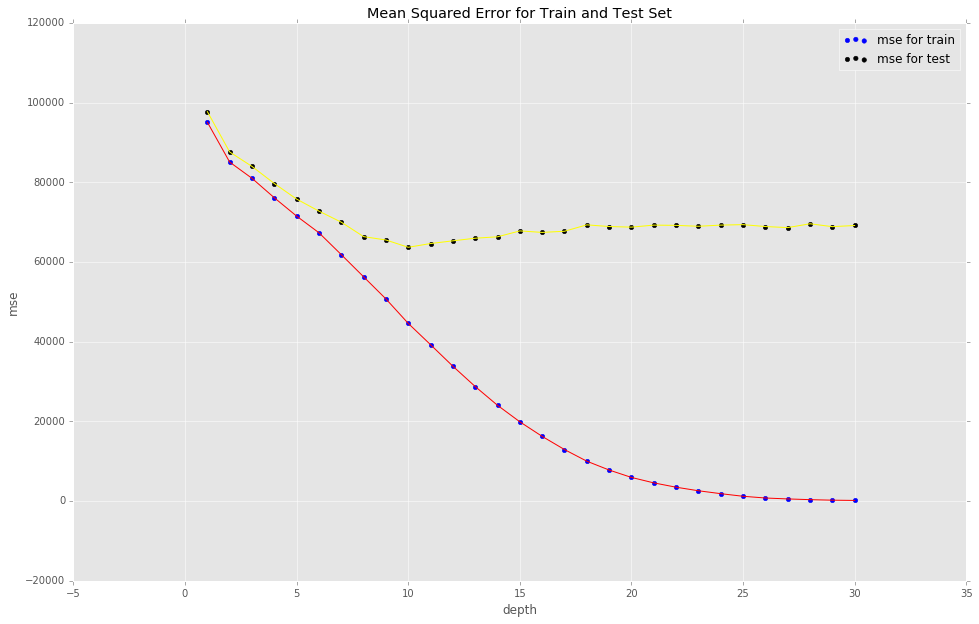

In [19]:
x = np.arange(1, 31, 1)
plt.figure(figsize = [16,10])
plt.scatter(x, train, color = 'blue', label="mse for train")
plt.scatter(x, test, color = "black",label="mse for test")
plt.plot(x, train, color = 'red')
plt.plot(x, test, color = 'yellow')

plt.xlabel("depth")
plt.ylabel("mse")
plt.title("Mean Squared Error for Train and Test Set")
plt.legend()


### Видно из графика, что при глубине 10 дотигается минимальная ошибка на тестовой выборке, следовательно, ее и нужно выбрать. Однако проверим

In [20]:
for t in range(30):
    if test[t] == min(test):
        print("При глубине", t+1, 'достигаетсся минимальная ср. кв. ошибка на тестовой выборке')
        print("Эта ошибка равна", test[t])
    elif train[t] == min(train):
        print("При глубине", t+1, 'достигаетсся минимальная ср. кв. ошибка на тренировочной выборке')
        print("Эта ошибка равна", train[t])
       

При глубине 10 достигаетсся минимальная ср. кв. ошибка на тестовой выборке
Эта ошибка равна 63678.6351027
При глубине 30 достигаетсся минимальная ср. кв. ошибка на тренировочной выборке
Эта ошибка равна 162.844248759


**Задание 2:** Выведите важности признаков. Для этого воспользуйтесь `DecisionTreeRegressor.feature_importances_`

In [21]:
reg = tree.DecisionTreeRegressor()
reg = reg.fit(X_train, y_train)
array = reg.feature_importances_
for x in range(8):
    print("Важность признака", df.columns[x], ":", array[x])
    if array[x] == max(array):
        m = df.columns[x]

print("Самый важный признак:", m)

Важность признака Longitude : 0.162590632133
Важность признака Latitude : 0.16472952271
Важность признака HousingMedianAge : 0.063575703428
Важность признака TotalRooms : 0.0217714844412
Важность признака TotalBedrooms : 0.021146154019
Важность признака Population : 0.0297826916902
Важность признака Households : 0.0172187303286
Важность признака MedianIncome : 0.51918508125
Самый важный признак: MedianIncome


**Задание 3:** Поразмышляйте на темы:
* Обработки пропусков в данных.
* Как сделать разделяющие плоскости непараллельные осям?

## Обработка пропусков данных

#### С использованием вероятности

Обработку пропусков данных можно разделить на два этапа:
Если мы встретили пропуск во время обучения, можно просто удалить данный объект и продолжать обучение на оставшихся. Однако если мы встретим такой объект на тестовой выборке, просто пропустить его не удастся, поэтому еще на стадии обучения нужно посчитать какая доля объектов в узле дерева данного признака уходит в правую подветвь, а какая в левую - т.е. если имеем признак пол, то посчитать сколько всего мужчин, а сколько женщин. Таким образом, мы будем знать вероятность какогото признака пойти в правую или левую ветвь, поэтому когда на этапе тестовой выборки алгоритм столкнется с пропуском, с полученными ранее вероятностями отправлять объет в правую или левую подветвь.

Идея - курсера, курс "Введение в машинное обучение"

#### Среднее значение

Если признак непрерывный. Идея остается такой же, но вместо пропуска берется среднее значение признака для всех объектов. Пример - возраст работника. На обучающей выборке данный работник пропускается, а на тестовой такому работнику будет присвоен возраст равный среднему по всей выборке и затем, с таким "возрастом" согласно критерию в вершине дерева он пойдет в левое или правое поддерево.

## Непаралелльные осям разделяющие плоскости

Обычно в вершинах деревьях наши условия стостоят в том, является ли признак объекта больше или меньше какого-то граничного значения, или принадлежит ли классу в случае категориального признака. Соответственно разделяющие плоскости будут паралелльными осям, если же в вершине сделать условие, включающее в себя, например, значение двух признаков, то плоскость преобразуется в непаралелльню прямую в пространстве значений двух этих признаков. Например, если использовать линейную комбинацбю признаков возраст и стаж работы, и отправлять в каждую подветвь в зависимости от значения уже не самих значений признаков для объекта, а их линейной комбинации